# Existing PAC Tools Comparisons

#### Written by: David C.C. Lu

This notebook provides a sensitivity analysis on comparing the performance of MSPACMan against existing PAC tools also developed in Python programming language.

The following comparisons are made for each tool:
* Determine the center of each PAC mass in the comodulogram;
* Determine the PAC strength tracking performance;
* Compare the comodulogram computation time.

For more information read the following notebooks:
* [Notes on PAC generator](Notes_PAC_Generator.ipynb): This notebook describes how PAC signals are generated in the analysis performed here.
* [Notes on PAC methods](Notes_PAC_Method.ipynb): This notebook described in detail how each PAC computation method are formulated.

# Overview

In order to properly set up the comparison, a number of PAC signals are generated.

* [Generate a Test Signal](#gen_test_signal)
* [PAC Comodulogram Processing](#comod_procs)
    * [PACTools](#pactools_)
    * [MSPACMan](#mspacman_)
    * [PACPy](#pacpy_)
* [Plots](#plots)
    * [Get Blobs to Identify Mass of PAC in the Comodulogram](#get_blobs)
    * [Plot Comparison Results](#plot_results)

In [15]:
# Import all system modules
import os
import sys
import time

# Import all scientific modules
%matplotlib inline

import numpy as np

import warnings

from mspacman import (PhaseAmplitudeCoupling, PACGenerator)
from pactools import Comodulogram, REFERENCES
import pacpy

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LogNorm

<a id=gen_test_signal></a>
# Generate a Test Signal

Review this [notebook on PAC generator](Notes_PAC_Generator.ipynb) to understand how the signals are generated. In this notebook, the signals are generated here rather than using `'pacgen_raw.fif'`, because we want the ability to change the parameters of the generated signals.

Additionally, each channel of the signal are varied by noise `num` times in order to apply statistical analysis to accomodate for variations observed in the results.

In [2]:
fs = 2**14
tdur = 8
num = 10

fp_i, fa_i = 16, 130

sig = {
    'vary_pac': 0,
    'vary_fph': 0,
    'vary_fam': 0,
}

pg = {
    'vary_pac': 0,
    'vary_fph': 0,
    'vary_fam': 0,
}

In [3]:
pg['vary_pac'] = PACGenerator(freq_phase=fp_i, freq_amp=fa_i, scale_phase=1, scale_amp=.25, phase_amp=np.pi, sample_rate=fs, seed=False)
sig['vary_pac'] = np.zeros((7, num, fs * tdur))
for i in range(num):
    sig['vary_pac'][:,i,:] = pg['vary_pac'].simulate(n=fs * tdur, pac=[0, 0.2, 0.4, 0.6, 0.8, 0.9, 1], noise=True)

(7, 10, 131072) (4, 10, 131072)


(0, 16384)

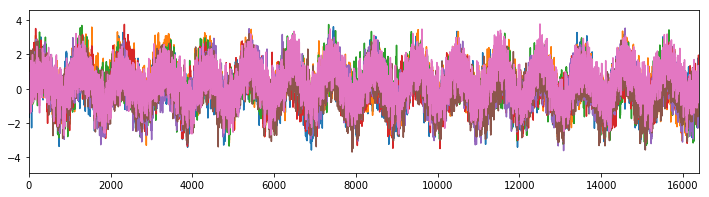

In [4]:
plt.figure(figsize=(12, 3))
plt.plot(sig['vary_pac'].T[:,-1])
plt.xlim([0, 2**14])

<a id=comod_procs></a>
# PAC Comodulogram Processing

In [5]:
# Simulation Parameters
# -----------------------------------------
dp = 3
da = 30
fpsize = 15
fasize = 15

p_range = (6, 50)
a_range = (60, 500)

fp = np.arange(*p_range, int(np.ceil(np.diff(p_range)/fpsize)), dtype=int)
fa = np.arange(*a_range, int(np.ceil(np.diff(a_range)/fasize)), dtype=int)

f_lo = np.asarray([(p-dp, p+dp) for p in fp])
f_hi = np.asarray([(a-da, a+da) for a in fa])

# Initialize
comod_ = {
    'pactools': np.zeros((num, pg['vary_pac'].nch, fpsize, fasize)),
    'pacpy': np.zeros((num, pg['vary_pac'].nch, 15, 15)),
    'mspacman': np.zeros((num, pg['vary_pac'].nch, fpsize, fasize))
}

time_ = {
    'pactools': np.zeros((pg['vary_pac'].nch, num)),
    'pacpy': np.zeros((pg['vary_pac'].nch, num//3)),
    'mspacman':np.zeros((pg['vary_pac'].nch, num))
}

<a id=pactools_></a>
## PACTools

In [6]:
obj = Comodulogram(fs=fs, low_fq_range=fp, low_fq_width=dp,
                    high_fq_range=fa, high_fq_width=da,
                    method='tort', progress_bar=False)


for ch in range(pg['vary_pac'].nch):
    for i in range(num):
        t0 = time.time()
        obj.fit(sig['vary_pac'][ch,i,:])
        comod_['pactools'][i,ch,:,:] = obj.comod_
        time_['pactools'][ch, i] = time.time() - t0
        
    print(ch, np.round(time_['pactools'][ch,:].mean(), 3), np.round(time_['pactools'][ch,:].sum(), 3))

0 1.341 13.407
1 1.375 13.753
2 1.352 13.516
3 1.346 13.462
4 1.38 13.8
5 1.36 13.601
6 1.321 13.206


<a id=mspacman_></a>
## MSPACMan

In [7]:
mi = PhaseAmplitudeCoupling(nch=1, nsamp=fs*tdur, freq_phase=f_lo, freq_amp=f_hi, sample_rate=fs, \
                            nprocs=3, pac='mi', mprocs=True)

for ch in range(pg['vary_pac'].nch):
    for i in range(num):
        t0 = time.time()
        comod_['mspacman'][i,ch,:,:] = mi.comodulogram(np.atleast_2d(sig['vary_pac'][ch,i,:]))
        time_['mspacman'][ch,i] = time.time() - t0
    print(ch, np.round(time_['mspacman'][ch,:].mean(), 3), np.round(time_['mspacman'][ch,:].sum(), 3))
mi.kill()

INFO:<class 'pytf.filter.filterbank.FilterBank'>:Creating the FilterBank class.
/Users/davidlu/.virtualenvs/py-phd/lib/python3.6/site-packages/pytf-0.1-py3.6.egg/pytf/filter/filterbank.py:338: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
INFO:<class 'pytf.filter.filterbank.FilterBank'>:Created the prototype filter.
INFO:<class 'pytf.filter.filterbank.FilterBank'>:Initialized FilterBank.
INFO:<class 'pytf.filter.filterbank.FilterBank'>:Creating the FilterBank class.
INFO:<class 'pytf.filter.filterbank.FilterBank'>:Created the prototype filter.
INFO:<class 'pytf.filter.filterbank.FilterBank'>:Initialized FilterBank.


0 0.064 0.639
1 0.062 0.625
2 0.063 0.629
3 0.063 0.629
4 0.063 0.634
5 0.064 0.638
6 0.064 0.643


<a id=pacpy_></a>
## PACPy

In [8]:
for ch in range(pg['vary_pac'].nch):
    for i in range(num//3):
        t0 = time.time()
        comod_['pacpy'][i, ch,:,:] = pacpy.pac.comodulogram(sig['vary_pac'][ch,i,:], sig['vary_pac'][ch,i,:], \
                                                            p_range, a_range, dp, da, fs=fs, w_lo=3, w_hi=3, pac_method='mi_tort')
        time_['pacpy'][ch,i] = time.time() - t0
        
    print(ch, np.round(time_['pacpy'][ch,:].mean(), 3), np.round(time_['pacpy'][ch,:].sum(), 3))

0 14.8 44.4
1 14.264 42.791
2 13.585 40.754
3 13.482 40.446
4 13.677 41.031
5 13.835 41.505
6 14.069 42.207


<a id=plots></a>
# Plots

<a id=get_blobs></a>
## Generate Blobs to Identify Mass of PAC in the Comodulogram

### Blob Properties

In [9]:
# 'comod_' is the comodulogram of different Python packages
# 'time_' is the ndarray of computation time of each Python packages

# Find Blobs
# First normalize the comodulogram
comod_norm = {
    'pactools': 0,
    'pacpy': 0,
    'mspacman': 0
}

blob_dim = {
    'pactools': np.zeros((pg['vary_pac'].nch,), dtype=np.object),
    'pacpy': np.zeros((pg['vary_pac'].nch,), dtype=np.object),
    'mspacman': np.zeros((pg['vary_pac'].nch,), dtype=np.object)
}

blob_prop = {
    'pactools': np.zeros((pg['vary_pac'].nch,), dtype=np.object),
    'pacpy': np.zeros((pg['vary_pac'].nch,), dtype=np.object),
    'mspacman': np.zeros((pg['vary_pac'].nch,), dtype=np.object)
}

keys = ['pactools', 'pacpy', 'mspacman']
for k in keys:
    comod_norm[k] = comod_[k][0,:,:,:] / np.max(comod_[k][0,:,:,:])
    for ch in range(pg['vary_pac'].nch):
        blob_dim[k][ch], blob_prop[k][ch] = PhaseAmplitudeCoupling.find_pac_blob(comod_norm[k][ch,:,:], \
                                                                                 vmax=comod_[k][0,:,:,:].max(),\
                                                                                 threshold=.5)

### Convert the Blob Dimensions into Frequency Units

In [10]:
fp_ = np.arange(p_range[0], p_range[1], dp)
fa_ = np.arange(a_range[0], a_range[1], da)

f_property = {
    'pactools': {
        'center': (fp[int(blob_prop['pactools'][ch]['center_mass'][0])], fa[int(blob_prop['pactools'][ch]['center_mass'][1])]),
        'width': np.diff(fp).mean() * blob_dim['pactools'][ch]['width'],
        'height': np.diff(fa).mean() * blob_dim['pactools'][ch]['height']},
    
    'mspacman': {
        'center': (fp[int(blob_prop['mspacman'][ch]['center_mass'][0])], fa[int(blob_prop['mspacman'][ch]['center_mass'][1])]),
        'width': np.diff(fp).mean() * blob_dim['mspacman'][ch]['width'],
        'height': np.diff(fa).mean() * blob_dim['mspacman'][ch]['height']},

    'pacpy': {
        'center': (fp_[int(blob_prop['pacpy'][ch]['center_mass'][0])], fa_[int(blob_prop['pacpy'][ch]['center_mass'][1])]),
        'width': np.diff(fp_).mean() * blob_dim['pacpy'][ch]['width'],
        'height': np.diff(fa_).mean() * blob_dim['pacpy'][ch]['height']},
}

### Select the Region of PAC in Comodulogram

In [11]:
slices = {}
for k in keys:
    x1, x2 = int(blob_prop[k][ch]['center_mass'][0] - blob_dim[k][ch]['width'] // 2), \
             int(blob_prop[k][ch]['center_mass'][0] + blob_dim[k][ch]['width'] // 2)

    y1, y2 = int(blob_prop[k][ch]['center_mass'][1] - blob_dim[k][ch]['height'] // 2), \
             int(blob_prop[k][ch]['center_mass'][1] + blob_dim[k][ch]['height'] // 2)

    slices[k] = (slice(x1, x2), slice(y1, y2))

In [12]:
pacs = {}
for k in keys:
    idx1, idx2 = slices[k]
    pacs[k] = np.mean(np.mean(comod_[k][0,:,idx1, idx2], axis=1), axis=-1)

<a id=plot_results></a>
## Plot Comparison Results

The results shown here is the processing of PAC with resolution of (15 x 15), at sampling rate of 16384 Hz, for the duration of 8.0 s.


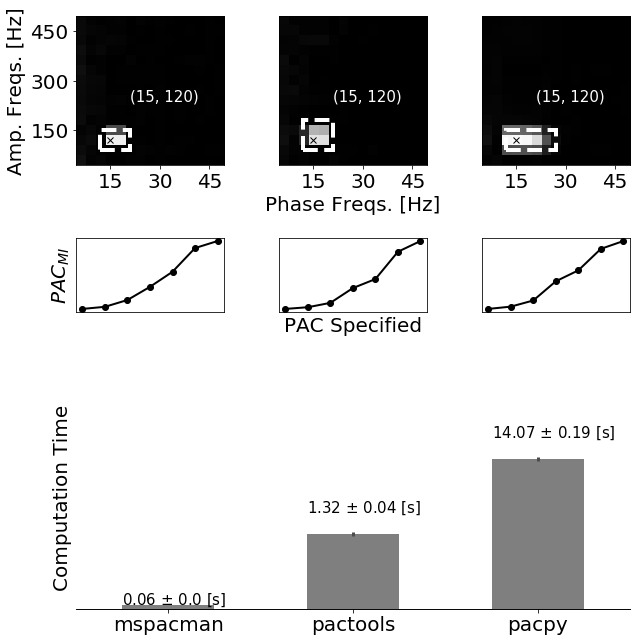

In [13]:
from matplotlib.patches import Rectangle

ch = 6
index = 0
opacity = 1
bar_width = 0.5
error_config = {'ecolor': '0.3', 'lw':3}

fig = plt.figure(figsize=(9, 9))
gs1_pac = GridSpec(3, 3, height_ratios=[2,1,3])
gs1_pac.update(hspace=0.1, left=.25, right=.75)

ax11 = plt.subplot(gs1_pac[0, 0])
ax12 = plt.subplot(gs1_pac[0, 1])
ax13 = plt.subplot(gs1_pac[0, 2])
ax21 = plt.subplot(gs1_pac[1, 0])
ax22 = plt.subplot(gs1_pac[1, 1])
ax23 = plt.subplot(gs1_pac[1, 2])
ax2 = plt.subplot(gs1_pac[2, :])

ax11.imshow(comod_['mspacman'][0,ch,:,:].T, vmin=comod_['mspacman'].min(), vmax=comod_['mspacman'].max(),\
            interpolation=None, origin='lower', aspect='auto', cmap='gray'
           )

ax12.imshow(comod_['pactools'][0,ch,:,:].T, vmin=comod_['pactools'].min(), vmax=comod_['pactools'].max(),\
            interpolation=None, origin='lower', aspect='auto', cmap='gray'
           )

ax13.imshow(comod_['pacpy'][0,ch,:,:].T, vmin=comod_['pacpy'].min(), vmax=comod_['pacpy'].max(),\
            interpolation=None, origin='lower', aspect='auto', cmap='gray'
           )

ax21.plot(pacs['mspacman'],'o-', c='k', lw=2)
ax22.plot(pacs['pactools'],'o-', c='k', lw=2)
ax23.plot(pacs['pacpy'],'o-', c='k', lw=2)

ax2.bar(index, time_['mspacman'][ch,:].mean(), bar_width,
                 alpha=opacity,
                 color='C7',
                 yerr=time_['mspacman'][ch,:].std(),
                 error_kw=error_config,
                 label='mspacman')

ax2.bar(index + bar_width * 2, time_['pactools'][ch,:].mean(), bar_width,
                 alpha=opacity,
                 color='C7',
                 yerr=time_['pactools'][ch,:].std(),
                 error_kw=error_config,
                 label='pactools')

ax2_ = ax2.twinx()
ax2_.bar(index + bar_width * 4, time_['pacpy'][ch,:].mean(), bar_width,
                 alpha=opacity,
                 color='C7',
                 yerr=time_['pacpy'][ch,:].std(),
                 error_kw=error_config,
                 label='pacpy')

ax11.plot(*blob_prop['mspacman'][ch]['center_mass'], 'x', c='k')
ax12.plot(*blob_prop['pactools'][ch]['center_mass'], 'x', c='k')
ax13.plot(*blob_prop['pacpy'][ch]['center_mass'], 'x', c='k')

r1 = Rectangle(xy=(blob_prop['mspacman'][ch]['center'][0]-blob_dim['mspacman'][ch]['width']//2,\
                   blob_prop['mspacman'][ch]['center'][1]-blob_dim['mspacman'][ch]['height']//2), \
              width=blob_dim['mspacman'][ch]['width'], height=blob_dim['mspacman'][ch]['height'], \
              fill=False, linewidth=4, color='w', linestyle='--')
ax11.add_artist(r1)

r2 = Rectangle(xy=(blob_prop['pactools'][ch]['center'][0]-blob_dim['pactools'][ch]['width']//2,\
                   blob_prop['pactools'][ch]['center'][1]-blob_dim['pactools'][ch]['height']//2), \
              width=blob_dim['pactools'][ch]['width'], height=blob_dim['pactools'][ch]['height'], \
              fill=False, linewidth=4, color='w', linestyle='--')
ax12.add_artist(r2)

r3 = Rectangle(xy=(blob_prop['pacpy'][ch]['center'][0]-blob_dim['pacpy'][ch]['width']//2,\
                   blob_prop['pacpy'][ch]['center'][1]-blob_dim['pacpy'][ch]['height']//2), \
              width=blob_dim['pacpy'][ch]['width'], height=blob_dim['pacpy'][ch]['height'], \
              fill=False, linewidth=4, color='w', linestyle='--')
ax13.add_artist(r3)

# ax11.set_title('mspacman', fontsize=20)
ax11.set_yticks([3, 8, 13])
ax11.set_yticklabels(['150', '300', '450'], fontsize=20)
ax11.set_xticks([3, 8, 13])
ax11.set_xticklabels(['15', '30', '45'], fontsize=20)
# ax11.set_xlabel('Phase Freqs. [Hz]', fontsize=15)
ax11.set_ylabel('Amp. Freqs. [Hz]', fontsize=20)

# ax12.set_title('pactools', fontsize=20)
ax12.set_yticks([])
ax12.set_xticks([3, 8, 13])
ax12.set_xticklabels(['15', '30', '45'], fontsize=20)
ax12.set_xlabel('Phase Freqs. [Hz]', fontsize=20)

# ax13.set_title('pacpy', fontsize=20)
ax13.set_yticks([])
ax13.set_xticks([3, 8, 13])
ax13.set_xticklabels(['15', '30', '45'], fontsize=20)
# ax13.set_xlabel('Phase Freqs. [Hz]', fontsize=15)

ax21.set_yticks([])
ax22.set_yticks([])
ax23.set_yticks([])

ax21.set_xticks([])
ax22.set_xticks([])
ax23.set_xticks([])
ax22.set_xlabel('PAC Specified', fontsize=20)
ax21.set_ylabel(r'$PAC_{MI}$', fontsize=20)


ax11.text(blob_prop['mspacman'][ch]['center_mass'][0]+2,\
          blob_prop['mspacman'][ch]['center_mass'][0]+3,\
          '({}, {})'.format(fp[blob_prop['mspacman'][ch]['center_mass'][0]],\
                            fa[blob_prop['mspacman'][ch]['center_mass'][1]]),
          fontsize=15, color='w')

ax12.text(blob_prop['mspacman'][ch]['center_mass'][0]+2,\
          blob_prop['mspacman'][ch]['center_mass'][0]+3,\
          '({}, {})'.format(fp[blob_prop['pactools'][ch]['center_mass'][0]],\
                            fa[blob_prop['pactools'][ch]['center_mass'][1]]),
          fontsize=15, color='w')

ax13.text(blob_prop['mspacman'][ch]['center_mass'][0]+2,\
          blob_prop['mspacman'][ch]['center_mass'][0]+3,\
          '({}, {})'.format(fp[blob_prop['pacpy'][ch]['center_mass'][0]],\
                            fa[blob_prop['pacpy'][ch]['center_mass'][1]]),
          fontsize=15, color='w')

ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_yticks([])
ax2.set_xticks([0, 1, 2])
ax2.set_xticklabels(['mspacman', 'pactools', 'pacpy'], fontsize=20)
ax2.set_ylabel('Computation Time', fontsize=20)
ax2.set_xlim([-0.5, 2.5])
ax2.set_ylim([0, time_['pactools'][ch,:].mean()*3])

ax2.text(index-.25, time_['mspacman'][ch,:].mean()*1.3, r'{} $\pm$ {} [s]'.format(round(time_['mspacman'][ch,:].mean(), 2),
                                round(time_['mspacman'][ch,:].std(), 2)), fontsize=15)

ax2.text((index + bar_width*2)-.25, time_['pactools'][ch,:].mean()*1.3, r'{} $\pm$ {} [s]'.format(round(time_['pactools'][ch,:].mean(), 2),
                                round(time_['pactools'][ch,:].std(), 2)), fontsize=15)

ax2_.spines['top'].set_visible(False)
ax2_.spines['left'].set_visible(False)
ax2_.spines['right'].set_visible(False)
ax2_.set_yticks([])
ax2_.set_ylim([0, time_['pacpy'][ch,:].mean()*1.5])
ax2_.text((index + bar_width*4)-.25, time_['pacpy'][ch,:].mean()*1.15, r'{} $\pm$ {} [s]'.format(round(time_['pacpy'][ch,:].mean(), 2),
                                round(time_['pacpy'][ch,:].std(), 2)), fontsize=15)
with warnings.catch_warnings():
    warnings.simplefilter("ignore", UserWarning)
    # This raises warnings since tight layout cannot
    # handle gridspec automatically. We are going to
    # do that manually so we can filter the warning.
    gs1_pac.tight_layout(fig, h_pad=2)

print("The results shown here is the processing of PAC with \
resolution of ({} x {}), at sampling rate of {} Hz, for the duration of {} s.".format(fpsize, fasize, fs, sig['vary_pac'].shape[-1]/fs))

In [14]:
save_plot = False

path_to_save1 = os.path.realpath(os.path.join(os.getcwd(),'compare_pac_dec.eps'))
if save_plot:
    fig.savefig(path_to_save1)